In [ ]:
!pip install piml

# Data Pipeline

In [3]:
from piml import Experiment
exp = Experiment()
exp.data_loader(data='CaliforniaHousing_trim2')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [4]:
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [8]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [18]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

# Model Pipeline

In [ ]:
from xgboost import XGBRegressor
XGB5 = XGBRegressor(max_depth=5, n_estimators=500)
exp.model_train(model = XGB5, name='XGB5')

In [ ]:
from sklearn.neural_network import MLPRegressor
ReLUDNN = MLPRegressor(hidden_layer_sizes=[40]*4, activation="relu",
                       random_state=0)
exp.model_train(model = ReLUDNN, name='ReLUDNN')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

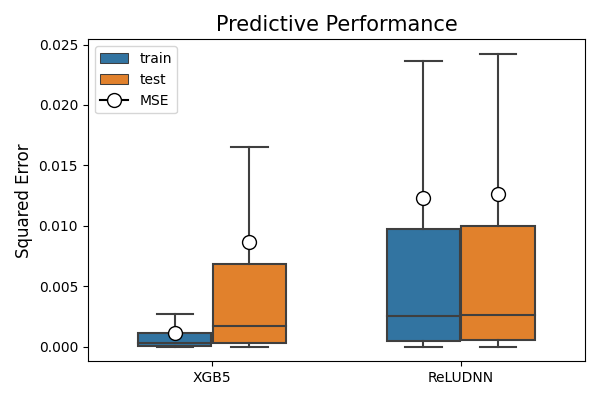

In [31]:
exp.model_compare(models=["XGB5", "ReLUDNN"], show="accuracy_plot",
                  metric="MSE", figsize=(6, 4))

# Model Diagnostics

## Error Analysis

- Assess models as usual by accuracy and residuals
- Apply error slicing to identify regions with underfitting/overfitting weakness

In [45]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

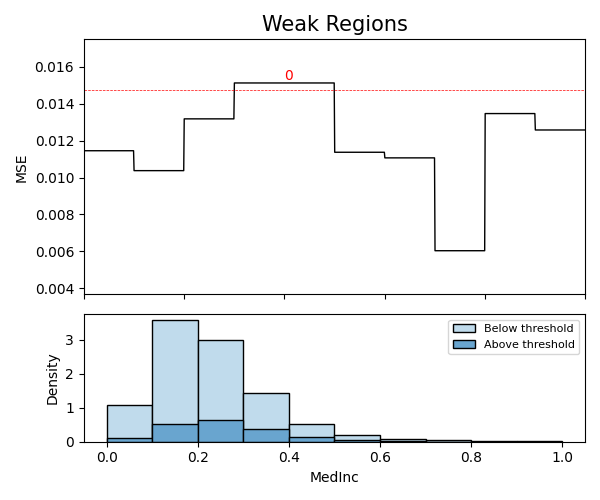

In [39]:
exp.model_diagnose(model="ReLUDNN", show="weakspot", metric="MSE",
                   slice_method="histogram", slice_features=["MedInc"],
                   threshold=1.2, min_samples=20, use_test=False, figsize=(6,5))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

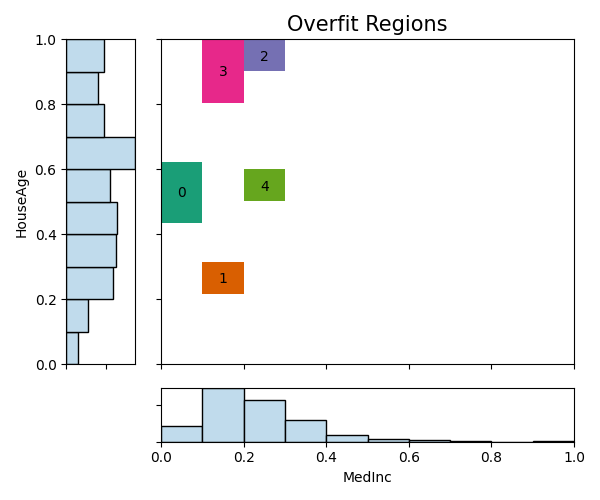

In [44]:
exp.model_diagnose(model="ReLUDNN", show="overfit", metric="MSE",
                   slice_method="histogram", slice_features=["MedInc", "HouseAge"],
                   threshold=1.2, min_samples=100, figsize=(6, 5))

## Resilience Test

- Run exp.model_diagnose() choose "Resilience" Tab
- Choose resilient scenarios: worst-sample, worst-cluster
- Measure distribution drift by PSI
- Verify sensitive/vulnerable variables by WeakSpot

In [46]:
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

## Segmented Diagnostics

- Data clustering through K-Means
- Demo use of PiML scored_test APIs for check performance heterogeneity

In [125]:
from sklearn.cluster import KMeans
x, y, _ = exp.get_data()
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)
segmodel = KMeans(n_clusters=6, random_state=0)
segmodel.fit(train_x)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

KMeans(n_clusters=6, random_state=0)

In [126]:
# Wrap segmented scored data
TargetModel = 'ReLUDNN'
train_idx, test_idx = exp.get_model(TargetModel).get_train_test_idx()
prediction = exp.get_model(model=TargetModel).estimator.predict(x)

trainx_seg_idx = segmodel.predict(train_x)
testx_seg_idx = segmodel.predict(test_x)

seg_scored_data = {}
for SegID in range(segmodel.n_clusters):
    scored_data = {'x': x,
                        'y': y,
                        'prediction': prediction,
                        'train_idx': train_idx[trainx_seg_idx == SegID],
                        'test_idx': test_idx[testx_seg_idx == SegID],
                        'feature_names': exp.get_feature_names(),
                        'feature_types': exp.get_feature_types()}
    seg_scored_data[SegID] = scored_data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [127]:
from piml.scored_test import test_accuracy, residual_plot, slicing_weakspot
import ipywidgets as widgets
import pandas as pd

test_mse_list = []
for SegID in range(segmodel.n_clusters):
    with widgets.Output():
      res = test_accuracy(**seg_scored_data[SegID])[0]
      test_mse_list.append(res['MSE'][1])
pd.DataFrame(test_mse_list, columns =['MSE'], dtype = float)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,MSE
0,0.0155
1,0.0135
2,0.0077
3,0.0082
4,0.0178
5,0.0132


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

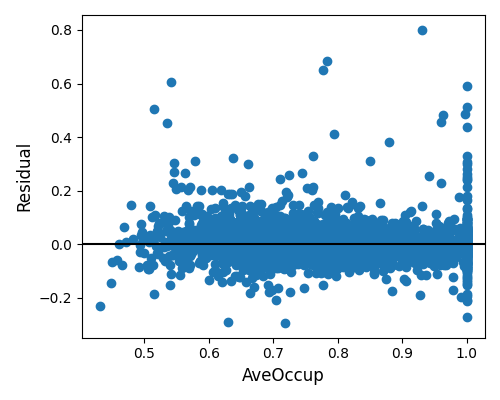

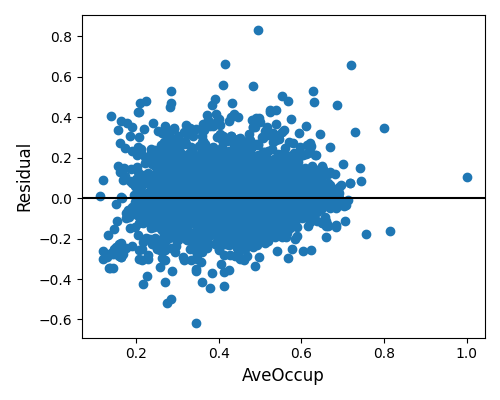

In [142]:
SegID = 2 # Best-performing
res = residual_plot(show_feature='AveOccup', **seg_scored_data[SegID], figsize=(5,4))
SegID = 4 # Worst-performing
res = residual_plot(show_feature='AveOccup', **seg_scored_data[SegID], figsize=(5,4))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

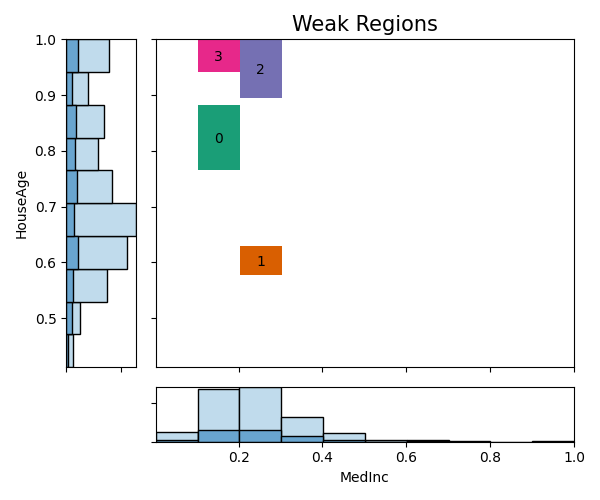

In [146]:
SegID = 4
res = slicing_weakspot(**seg_scored_data[SegID], slice_features=["MedInc", "HouseAge"],
                       threshold=1.2, slice_method="histogram",
                       min_samples=20, figsize=(6, 5))